# Modeling Song Popularity

## Introduction
The main goal of this project is to model the popularity of songs on Spotify, and look at what features are most likely to lead to a songs overall popularity. To acheive this we will use a variety of different regression models, both linear and non-linear. We will also be looking at the effectiveness of these models when used on such a large database to determine which model is best suited for this task and similar ones.

## About the data
The dataset was pulled from Kaggle, https://www.kaggle.com/datasets/devdope/900k-spotify, and contains many different features such as Artist, emotion, Genres, Tempo, with Popularity being our target value. The dataset says it contains 900K+ songs, however the .csv file we will be using has a little under 500K songs. An imprtant feature to note about this dataset is that the emotion feature was generated by an emotion detection model, and it is uncertain how accurate this model was in predicting emotions. It is also unclear how the dataset score the popularity of a song.

### Imports

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression,Ridge, Lasso, ElasticNet,LassoCV,RidgeCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.api as sm
import os
import warnings

### Look at the Data
Here we look at a breif overview of what the data looks like and contains.

In [10]:
df = pd.read_csv('spotify_dataset.csv')
df.head(3)

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
0,!!!,Even When the Waters Cold,Friends told her she was better off at the bot...,03:47,sadness,hip hop,Thr!!!er,2013-04-29,D min,0.437870,...,0,Corey Smith,If I Could Do It Again,0.986061,Toby Keith,Drinks After Work,0.983719,Space,Neighbourhood,0.983236
1,!!!,One Girl / One Boy,"Well I heard it, playing soft From a drunken b...",04:03,sadness,hip hop,Thr!!!er,2013-04-29,A# min,0.508876,...,0,Hiroyuki Sawano,BRE@TH//LESS,0.995409,When In Rome,Heaven Knows,0.990905,Justice Crew,Everybody,0.984483
2,!!!,Pardon My Freedom,"Oh my god, did I just say that out loud? Shoul...",05:51,joy,hip hop,Louden Up Now,2004-06-08,A Maj,0.532544,...,0,Ricky Dillard,More Abundantly Medley Live,0.993176,Juliet,Avalon,0.965147,The Jacksons,Lovely One,0.956752


Looking at the description of the Popularity feature, we can see the average popularity is low with an average score of 30. We also take a look at some of the more Popular songs in the database.

In [12]:
df['Popularity'].describe()

count    498052.000000
mean         30.486453
std          17.189269
min           0.000000
25%          19.000000
50%          28.000000
75%          40.000000
max         100.000000
Name: Popularity, dtype: float64

In [13]:
df.nlargest(5, 'Popularity')

,Artist(s),song,text,Length,emotion,Genre,Album,Release Date,Key,Tempo,...,Good for Morning Routine,Similar Artist 1,Similar Song 1,Similarity Score 1,Similar Artist 2,Similar Song 2,Similarity Score 2,Similar Artist 3,Similar Song 3,Similarity Score 3
46908,Billie Eilish,H.M.T,"[Chorus] How many timess will they tell me ""no...",03:30,sadness,"electronic,pop,electropop",HIT ME HARD AND SOFT,2024-05-17,D Maj,0.43787,...,1,Billie Eilish,Slipping Away Original Mix,0.999977,"Camila Cabello,Young Thug",Dont Call Me,0.978790,"Camila Cabello,Young Thug",Camila Cabello Daddy Yankee - Havana Remix En...,0.978790
46847,Billie Eilish,E.T.,[Chorus: B.o.B] Like I don't belong I feel lik...,03:30,anger,"electronic,pop,electropop",HIT ME HARD AND SOFT,2024-05-17,D Maj,0.43787,...,1,Billie Eilish,HI,1.000000,"Camila Cabello,Young Thug",Movin,0.980260,"Camila Cabello,Young Thug",4 Eva Bloody,0.980260
46882,Billie Eilish,HI,[Intro] Oh oh (yeah) Oh oh (Uh huh) Oh oh Oh o...,03:30,anger,"electronic,pop,electropop",HIT ME HARD AND SOFT,2024-05-17,D Maj,0.43787,...,1,Billie Eilish,E.T.,1.000000,"Camila Cabello,Young Thug",Movin,0.980260,"Camila Cabello,Young Thug",4 Eva Bloody,0.980260
46887,Billie Eilish,Birds of a Feather,[Verse 1] Met you in front of a diner and you ...,03:30,joy,"electronic,pop,electropop",HIT ME HARD AND SOFT,2024-05-17,D Maj,0.43787,...,1,Billie Eilish,So So,1.000000,"Camila Cabello,Young Thug",Havana No Rap Version,0.979954,"Camila Cabello,Young Thug",Pull Up,0.979954
46889,Billie Eilish,So So,"[Verse 1] Yes sir is Bobby Ray, aka A. B.o.B. ...",03:30,joy,"electronic,pop,electropop",HIT ME HARD AND SOFT,2024-05-17,D Maj,0.43787,...,1,Billie Eilish,Birds of a Feather,1.000000,"Camila Cabello,Young Thug",Havana No Rap Version,0.979954,"Camila Cabello,Young Thug",Pull Up,0.979954


## Data Preperation
Here we begin preparing the data to be used in the models. The first step is dropping the unnessesary columns that either wouldnt matter or would be to difficult and resource intensive to proccess. Then we look at the different datatypes present to see wheich fdeatures will need to be processed to be usable.

In [15]:
df=df.drop(columns=['Artist(s)','song','text','Album','Release Date','Similar Artist 1','Similar Song 1','Similarity Score 1','Similar Artist 2','Similar Song 2','Similarity Score 2','Similar Artist 3','Similar Song 3','Similarity Score 3'])
df.dtypes

Length                             object
emotion                            object
Genre                              object
Key                                object
Tempo                             float64
Loudness (db)                     float64
Time signature                     object
Explicit                           object
Popularity                          int64
Energy                              int64
Danceability                        int64
Positiveness                        int64
Speechiness                         int64
Liveness                            int64
Acousticness                        int64
Instrumentalness                    int64
Good for Party                      int64
Good for Work/Study                 int64
Good for Relaxation/Meditation      int64
Good for Exercise                   int64
Good for Running                    int64
Good for Yoga/Stretching            int64
Good for Driving                    int64
Good for Social Gatherings        

Next we check for and remove any null values that are within the dataset.

In [17]:
df.isna().sum()

Length                            0
emotion                           0
Genre                             0
Key                               0
Tempo                             0
Loudness (db)                     0
Time signature                    8
Explicit                          0
Popularity                        0
Energy                            0
Danceability                      0
Positiveness                      0
Speechiness                       0
Liveness                          0
Acousticness                      0
Instrumentalness                  0
Good for Party                    0
Good for Work/Study               0
Good for Relaxation/Meditation    0
Good for Exercise                 0
Good for Running                  0
Good for Yoga/Stretching          0
Good for Driving                  0
Good for Social Gatherings        0
Good for Morning Routine          0
dtype: int64

In [18]:
df=df.dropna()
df.isna().sum()

Length                            0
emotion                           0
Genre                             0
Key                               0
Tempo                             0
Loudness (db)                     0
Time signature                    0
Explicit                          0
Popularity                        0
Energy                            0
Danceability                      0
Positiveness                      0
Speechiness                       0
Liveness                          0
Acousticness                      0
Instrumentalness                  0
Good for Party                    0
Good for Work/Study               0
Good for Relaxation/Meditation    0
Good for Exercise                 0
Good for Running                  0
Good for Yoga/Stretching          0
Good for Driving                  0
Good for Social Gatherings        0
Good for Morning Routine          0
dtype: int64

Now we go through each feature that is an object and conver them into a usable int or float, either by replacing, getting dummies, or using onehot encoding.

#### Length
With the length I looped through the dataset, to a substring of each value, casted it into an int, and converted the minutes into seconds. This resulted in the length all being an int of how many second slong the song was.

In [21]:
len=df['Length']
length=[]
for row in len:
    temp=(int(row[0:2])*60)+int(row[3:])
    length.append(temp)
df['Length_Seconds'] = length
df.drop(['Length'], axis = 1, inplace = True)
df.head()

,emotion,Genre,Key,Tempo,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,...,Good for Party,Good for Work/Study,Good for Relaxation/Meditation,Good for Exercise,Good for Running,Good for Yoga/Stretching,Good for Driving,Good for Social Gatherings,Good for Morning Routine,Length_Seconds
0,sadness,hip hop,D min,0.437870,0.785065,4/4,No,40,83,71,...,0,0,0,0,0,0,0,0,0,227
1,sadness,hip hop,A# min,0.508876,0.805051,4/4,No,42,85,70,...,0,0,0,0,0,0,0,0,0,243
2,joy,hip hop,A Maj,0.532544,0.799419,4/4,No,29,89,71,...,0,0,0,1,0,0,0,0,0,351
3,joy,hip hop,A min,0.538462,0.811047,4/4,No,24,84,78,...,0,0,0,1,0,0,0,0,0,224
4,joy,hip hop,F min,0.544379,0.808321,4/4,No,30,71,77,...,0,0,0,1,0,0,0,0,0,360


#### Emotion
Looking at the list of uniquie emotions used, some of them are slightly unusual like True and Thirst, then looking at the counts for each emotion we see some only have a few songs tied to them so we simply remove the rows containg those, and since its such a large dataset this should be negligable.

In [23]:
set(df['emotion'].to_list())

{'Love',
 'True',
 'anger',
 'angry',
 'confusion',
 'fear',
 'interest',
 'joy',
 'love',
 'pink',
 'sadness',
 'surprise',
 'thirst'}

In [24]:
emotionCounts = df['emotion'].value_counts()
print(emotionCounts)

emotion
joy          189368
sadness      156808
anger         95489
fear          26001
love          25379
surprise       4974
True             17
pink              2
Love              2
angry             1
thirst            1
confusion         1
interest          1
Name: count, dtype: int64


In [25]:
to_remove = ['True','pink','Love','angry','thirst','confusion','interest']
df=df[~df['emotion'].isin(to_remove)]

In [26]:
counts = df['emotion'].value_counts()
print(counts)

emotion
joy         189368
sadness     156808
anger        95489
fear         26001
love         25379
surprise      4974
Name: count, dtype: int64


We then get dummies for each emotion and add them to the dataset.

In [28]:
emotion_dummies = pd.get_dummies(df['emotion'])
emotions = emotion_dummies.columns
for col in emotions:
    emotion_dummies[col] = emotion_dummies[col].replace([False, True], [0,1])
df = pd.concat([df, emotion_dummies], axis=1)
df.drop(['emotion'], axis = 1, inplace = True)
df.head()

C:\Users\carso\AppData\Local\Temp\ipykernel_18592\2999100739.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  emotion_dummies[col] = emotion_dummies[col].replace([False, True], [0,1])


,Genre,Key,Tempo,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,Positiveness,...,Good for Driving,Good for Social Gatherings,Good for Morning Routine,Length_Seconds,anger,fear,joy,love,sadness,surprise
0,hip hop,D min,0.437870,0.785065,4/4,No,40,83,71,87,...,0,0,0,227,0,0,0,0,1,0
1,hip hop,A# min,0.508876,0.805051,4/4,No,42,85,70,87,...,0,0,0,243,0,0,0,0,1,0
2,hip hop,A Maj,0.532544,0.799419,4/4,No,29,89,71,63,...,0,0,0,351,0,0,1,0,0,0
3,hip hop,A min,0.538462,0.811047,4/4,No,24,84,78,97,...,0,0,0,224,0,0,1,0,0,0
4,hip hop,F min,0.544379,0.808321,4/4,No,30,71,77,70,...,0,0,0,360,0,0,1,0,0,0


#### Explicit
Here we simply replace the yes and no values for the explicit feature with 1 and 0 respectively.

In [30]:
set(df['Explicit'].to_list())

{'No', 'Yes'}

In [31]:
explicitCounts = df['Explicit'].value_counts()
print(explicitCounts)

Explicit
No     359433
Yes    138586
Name: count, dtype: int64


In [32]:
df['Explicit'] = df['Explicit'].replace({'Yes':1,'No':0})
df.head()

C:\Users\carso\AppData\Local\Temp\ipykernel_18592\690674209.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Explicit'] = df['Explicit'].replace({'Yes':1,'No':0})


,Genre,Key,Tempo,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,Positiveness,...,Good for Driving,Good for Social Gatherings,Good for Morning Routine,Length_Seconds,anger,fear,joy,love,sadness,surprise
0,hip hop,D min,0.437870,0.785065,4/4,0,40,83,71,87,...,0,0,0,227,0,0,0,0,1,0
1,hip hop,A# min,0.508876,0.805051,4/4,0,42,85,70,87,...,0,0,0,243,0,0,0,0,1,0
2,hip hop,A Maj,0.532544,0.799419,4/4,0,29,89,71,63,...,0,0,0,351,0,0,1,0,0,0
3,hip hop,A min,0.538462,0.811047,4/4,0,24,84,78,97,...,0,0,0,224,0,0,1,0,0,0
4,hip hop,F min,0.544379,0.808321,4/4,0,30,71,77,70,...,0,0,0,360,0,0,1,0,0,0


#### Time Signature
Here we replace the time signature fractions with their correspoding decimals.

In [34]:
set(df['Time signature'].to_list())

{'1/4', '3/4', '4/4', '5/4'}

In [35]:
timeCounts = df['Time signature'].value_counts()
print(timeCounts)

Time signature
4/4    451489
3/4     34606
5/4      8546
1/4      3378
Name: count, dtype: int64


In [36]:
df['Time signature'] = df['Time signature'].replace({'1/4':0.25,'3/4':0.75,'4/4':1.0,'5/4':1.25,})
df.head()

C:\Users\carso\AppData\Local\Temp\ipykernel_18592\3409755690.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Time signature'] = df['Time signature'].replace({'1/4':0.25,'3/4':0.75,'4/4':1.0,'5/4':1.25,})


,Genre,Key,Tempo,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,Positiveness,...,Good for Driving,Good for Social Gatherings,Good for Morning Routine,Length_Seconds,anger,fear,joy,love,sadness,surprise
0,hip hop,D min,0.437870,0.785065,1.0,0,40,83,71,87,...,0,0,0,227,0,0,0,0,1,0
1,hip hop,A# min,0.508876,0.805051,1.0,0,42,85,70,87,...,0,0,0,243,0,0,0,0,1,0
2,hip hop,A Maj,0.532544,0.799419,1.0,0,29,89,71,63,...,0,0,0,351,0,0,1,0,0,0
3,hip hop,A min,0.538462,0.811047,1.0,0,24,84,78,97,...,0,0,0,224,0,0,1,0,0,0
4,hip hop,F min,0.544379,0.808321,1.0,0,30,71,77,70,...,0,0,0,360,0,0,1,0,0,0


#### Key
Here we get dummies for each of the key values and add them back into the dataframe.

In [38]:
key_dummies = pd.get_dummies(df['Key'])
keys = key_dummies.columns
for col in keys:
    key_dummies[col] = key_dummies[col].replace([False, True], [0,1])
df = pd.concat([df, key_dummies], axis=1)
df.drop(['Key'], axis = 1, inplace = True)
df.head()

C:\Users\carso\AppData\Local\Temp\ipykernel_18592\2669715638.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  key_dummies[col] = key_dummies[col].replace([False, True], [0,1])


,Genre,Tempo,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,...,E Maj,E min,F Maj,F min,F# Maj,F# min,G Maj,G min,G# Maj,G# min
0,hip hop,0.437870,0.785065,1.0,0,40,83,71,87,4,...,0,0,0,0,0,0,0,0,0,0
1,hip hop,0.508876,0.805051,1.0,0,42,85,70,87,4,...,0,0,0,0,0,0,0,0,0,0
2,hip hop,0.532544,0.799419,1.0,0,29,89,71,63,8,...,0,0,0,0,0,0,0,0,0,0
3,hip hop,0.538462,0.811047,1.0,0,24,84,78,97,4,...,0,0,0,0,0,0,0,0,0,0
4,hip hop,0.544379,0.808321,1.0,0,30,71,77,70,7,...,0,0,0,1,0,0,0,0,0,0


#### Genre
Since multiple genres could be listed for each song, onehot encoding was used to seperate all uniquie genres and then a 1 was placed in each genre if it appeared in that song.

In [40]:
set(df['Genre'].to_list())

{'psychedelic,indie pop',
 'pop rock,pop,country',
 'alternative rock,pop,synthpop',
 'pop,jazz,dance',
 'acoustic,soul',
 'experimental',
 'blues,grunge',
 'worship',
 'nu metal',
 'rock,electronic,indie',
 'electronic,experimental,techno',
 'pop rock,rock,synthpop',
 'country,classic rock,hard rock',
 'soul,funk',
 'reggae',
 'trip-hop,electronic,indie',
 'synthpop',
 'rock,alternative',
 'chillout,hip hop,lo-fi',
 'shoegaze,post-punk,indie rock',
 'alternative rock,synthpop',
 'alternative rock,hard rock',
 'trance,electronic,techno',
 'soul',
 'dream pop,shoegaze,indie rock',
 'hip hop,electronic',
 'rock,classical,progressive rock',
 'black metal,metal,post-hardcore',
 'indie rock,post-hardcore',
 'folk,rock,grunge',
 'pop,dancehall',
 'soul,hip hop,pop',
 'progressive rock,pop rock',
 'country,soul',
 'progressive metal,nu metal',
 'dance,rock,alternative rock',
 'hard rock,pop rock,rock',
 'rock,blues,psychedelic rock',
 'electronic,electro,dubstep',
 'pop,hip hop,rnb',
 'altern

In [41]:
df['Genre'] = df['Genre'].str.split(',')
one_hot=df['Genre'].explode().str.strip().str.lower()
one_hot_df = pd.get_dummies(one_hot).groupby(level=0).sum()
df = pd.concat([df, one_hot_df], axis=1)
df.drop(['Genre'], axis = 1, inplace = True)
df.head()

,Tempo,Loudness (db),Time signature,Explicit,Popularity,Energy,Danceability,Positiveness,Speechiness,Liveness,...,soul,soundtrack,swing,synthpop,techno,thrash metal,trance,trap,trip-hop,worship
0,0.437870,0.785065,1.0,0,40,83,71,87,4,16,...,0,0,0,0,0,0,0,0,0,0
1,0.508876,0.805051,1.0,0,42,85,70,87,4,32,...,0,0,0,0,0,0,0,0,0,0
2,0.532544,0.799419,1.0,0,29,89,71,63,8,64,...,0,0,0,0,0,0,0,0,0,0
3,0.538462,0.811047,1.0,0,24,84,78,97,4,12,...,0,0,0,0,0,0,0,0,0,0
4,0.544379,0.808321,1.0,0,30,71,77,70,7,10,...,0,0,0,0,0,0,0,0,0,0


## Data Exploration
Here we look at how the data we cleaned might correlate to Popularity. We Then take the absolute values of each feature and then use a bar plot to better visualize which feature might correlate best with Popularity. Looking at the Correlation graph, we can see that there is an overall low correlation which may lead to the models not being as accurate.

In [43]:
correlations = df.corr(numeric_only=True)['Popularity'].drop('Popularity').sort_values(ascending=False)

Good for Party                0.335937
Good for Social Gatherings    0.189955
hip hop                       0.153487
pop                           0.149564
trap                          0.114102
Speechiness                   0.110884
rap                           0.091241
rock                          0.085464
Loudness (db)                 0.082781
alternative rock              0.082630
k-pop                         0.081332
electropop                    0.080772
Positiveness                  0.072073
Danceability                  0.068495
reggae                        0.056888
Name: Popularity, dtype: float64


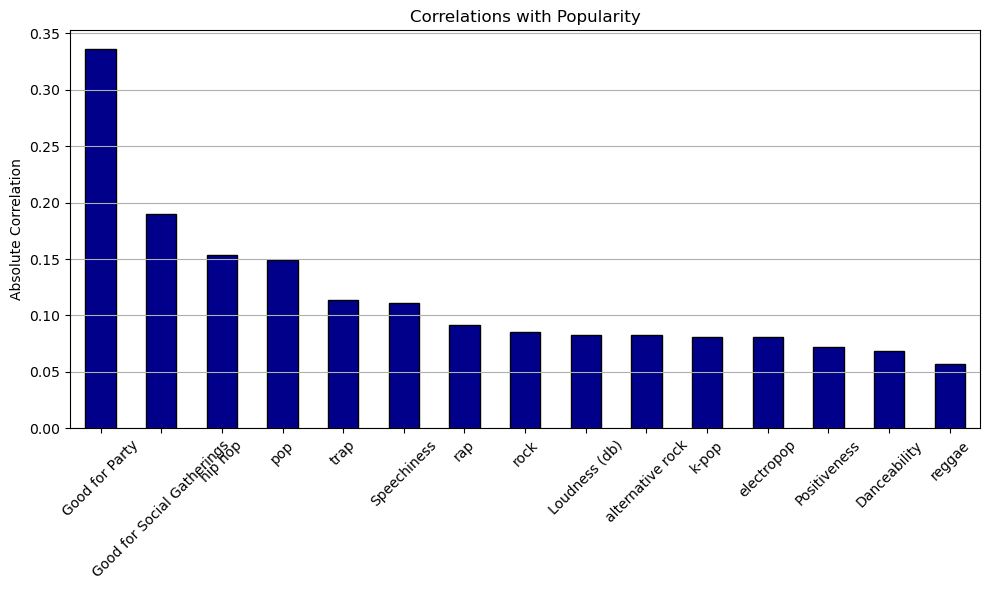

In [44]:
top15 = correlations.abs().sort_values(ascending=False).head(15)
print(top15)
plt.figure(figsize=(10, 6))
top15.plot(kind='bar', color='darkblue', edgecolor='black')
plt.title('Correlations with Popularity')
plt.ylabel('Absolute Correlation')
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

## Modeling
Here we begin modeling now that the data has been cleaned. We will be using 4 linear regression models, MLR, Lasso, Ridge, and Elasticnet, along with 2 non-linear Regresison models,Random Forest Regressor and Gradient Boosting. First we seperate out the Popularity feature.

In [46]:
X = df.drop('Popularity', axis =1)
Y = df['Popularity']

### MLR with Ordinary Least Squares
Multiple Linear Regression uses a line of best fit in order to try and predict the values. The Equation of this line being:
$$
y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \dots + \beta_n X_n
$$

 With $\beta_0$ as the intercept, y is the target variable, $X_n$ being the independent variables, and $\beta_n$ being the slopes
 We then look at the model and  iteravely drop the feature of least significance. Finally we evalute the model using RMSE and by its R2 score.

In [48]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state =79)
mlr_model = sm.OLS(Y_train, X_train).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Popularity   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     919.1
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        15:50:40   Log-Likelihood:            -1.6437e+06
No. Observations:              398415   AIC:                         3.288e+06
Df Residuals:                  398277   BIC:                         3.289e+06
Df Model:                         137                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Tempo       

In [49]:
p_threshold=0.05
features = list(X_train.columns)

while True:
    mlr_model = sm.OLS(Y_train, X_train[features]).fit()
    p_values = mlr_model.pvalues
    worst_pval = p_values.max()
    if worst_pval > p_threshold:
        worst_feature = p_values.idxmax()
        features.remove(worst_feature)
    else:
        break

mlr_model = sm.OLS(Y_train, X_train[features]).fit()
print(mlr_model.summary())

                            OLS Regression Results                            
Dep. Variable:             Popularity   R-squared:                       0.240
Model:                            OLS   Adj. R-squared:                  0.240
Method:                 Least Squares   F-statistic:                     1166.
Date:                Thu, 08 May 2025   Prob (F-statistic):               0.00
Time:                        15:51:34   Log-Likelihood:            -1.6437e+06
No. Observations:              398415   AIC:                         3.288e+06
Df Residuals:                  398306   BIC:                         3.289e+06
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Tempo       

In [50]:
mlr_pred=mlr_model.predict(X_test[features])
mlr_mse=mean_squared_error(Y_test,mlr_pred).round(2)
mlr_rmse=np.sqrt(mlr_mse).round(2)
mlr_r2=r2_score(Y_test,mlr_pred)
print(f"Multiple Linear Regression Evaluation:\n\nMean Squared Error: {mlr_mse}\nRoot Mean Squared Error: {mlr_rmse}\nR2 Score: {mlr_r2}")

Multiple Linear Regression Evaluation:

Mean Squared Error: 225.55
Root Mean Squared Error: 15.02
R2 Score: 0.23893311301843922


### Lasso Regression
Lasso Regression build off of OLS but differs in how it deals with coliniearity better, and introduces a penalty term $\lambda$, that reduces the coefficents of unimportant variables to 0. The equations for Lasso Regression is:
$$
Rss + \lambda * \sum|\beta_n|
$$
With $\lambda$ ebgin the penalty term anf $\beta_n$ represents the coefficients of the predictors


In [52]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state =80)
model = LassoCV(cv=5)
model.fit(X_train, Y_train)
las_model=Lasso(alpha=model.alpha_)
las_model.fit(X_train, Y_train)
las_pred=las_model.predict(X_test)
las_mse=mean_squared_error(Y_test,las_pred).round(2)
las_rmse=np.sqrt(las_mse).round(2)
las_r2=r2_score(Y_test,las_pred)
print(f"Lasso Regression Evaluation:\n\nAlpha: {model.alpha_}\nMean Squared Error: {las_mse}\nRoot Mean Squared Error: {las_rmse}\nR2 Score: {las_r2}")

Lasso Regression Evaluation:

Alpha: 0.04076872272598179
Mean Squared Error: 229.2
Root Mean Squared Error: 15.14
R2 Score: 0.22541923392696328


### Ridge Regression
Ridge regression was also tried due to possible multicollinearity among the variables.

In [54]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state =81)
ridge_cv = RidgeCV(cv=5)
ridge_cv.fit(X_train, Y_train)
rid_model=Ridge(alpha=ridge_cv.alpha_)
rid_model.fit(X_train, Y_train)
rid_pred=rid_model.predict(X_test)
rid_mse=mean_squared_error(Y_test,rid_pred).round(2)
rid_rmse=np.sqrt(rid_mse).round(2)
rid_r2=r2_score(Y_test,rid_pred)
print(f"Ridge Regression Evaluation:\n\nAlpha: {model.alpha_}\nMean Squared Error: {rid_mse}\nRoot Mean Squared Error: {rid_rmse}\nR2 Score: {rid_r2}")

Ridge Regression Evaluation:

Alpha: 0.04076872272598179
Mean Squared Error: 225.76
Root Mean Squared Error: 15.03
R2 Score: 0.23982980282327304


### ElasticNet
Elastic net was also tested since it can preform both the feature selection of Lasso and the handleing of multicolinearity of ridge regression. So the thought was that if  it could do both of these things it would preform better on the data.

In [56]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state =45)
ela_model=ElasticNet(alpha=0.1, l1_ratio=0.5)
ela_model.fit(X_train, Y_train)
ela_pred=ela_model.predict(X_test)
ela_mse=mean_squared_error(Y_test,ela_pred).round(2)
ela_rmse=np.sqrt(ela_mse).round(2)
ela_r2=r2_score(Y_test,ela_pred)
print(f"ElasticNet Evaluation:\n\nAlpha: {'0.1'}\nMean Squared Error: {ela_mse}\nRoot Mean Squared Error: {ela_rmse}\nR2 Score: {ela_r2}")

ElasticNet Evaluation:

Alpha: 0.1
Mean Squared Error: 250.49
Root Mean Squared Error: 15.83
R2 Score: 0.15384016555940627


### Random Forest Regressor
As linear regression models havent been yeilding much results we will try using some non linear models, here we will use Random Forest regressor, which works by takinging random subsets of data in multiple branches to create predictions and then averaging those predictions together.

In [58]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state =8)
for_model=RandomForestRegressor(n_estimators=10, random_state=22)
for_model.fit(X_train, Y_train)
for_pred=for_model.predict(X_test)
for_mse=mean_squared_error(Y_test,for_pred).round(2)
for_rmse=np.sqrt(for_mse).round(2)
for_r2=r2_score(Y_test,for_pred)
print(f"Random Forest Regressor Evaluation:\n\nMean Squared Error: {for_mse}\nRoot Mean Squared Error: {for_rmse}\nR2 Score: {for_r2}")

Random Forest Regressor Evaluation:

Mean Squared Error: 167.01
Root Mean Squared Error: 12.92
R2 Score: 0.4298311392952251


### Gradient Boosting
This non linear model was used due to how it combines multiple weak learner to create a strong predictive model, which should lead to a better overall model. 

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state =8)
gra_model=GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=10, random_state=65)
gra_model.fit(X_train, Y_train)
gra_pred=gra_model.predict(X_test)
gra_mse=mean_squared_error(Y_test,gra_pred).round(2)
gra_rmse=np.sqrt(gra_mse).round(2)
gra_r2=r2_score(Y_test,gra_pred)
print(f"Gradient Boosting Evaluation:\n\nMean Squared Error: {gra_mse}\nRoot Mean Squared Error: {gra_rmse}\nR2 Score: {gra_r2}")

Gradient Boosting Evaluation:

Mean Squared Error: 182.59
Root Mean Squared Error: 13.51
R2 Score: 0.3766440443403728


#### Comparing Models
The two charts shown below demonstrate the preformace of the 5 models previously used. It cleary demonstrates how the two non linear models preformed better than the linear ones, both in terms of R2 score and RMSE.

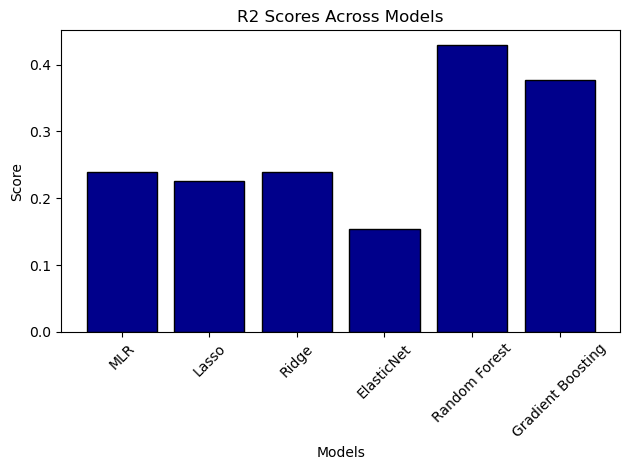

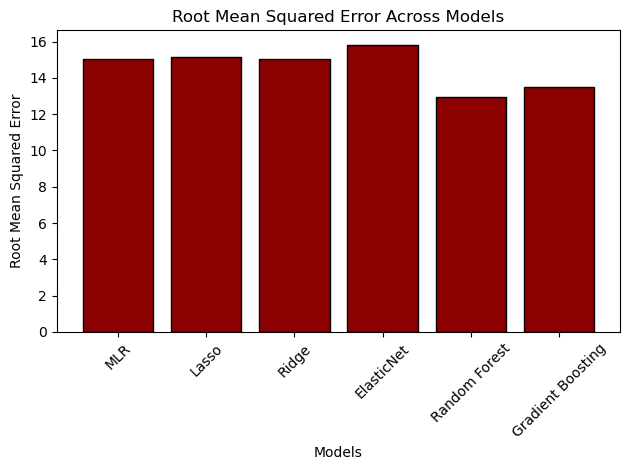

In [62]:
r2_scores=[mlr_r2,las_r2,rid_r2,ela_r2,for_r2,gra_r2]
labels = ['MLR', 'Lasso', 'Ridge', 'ElasticNet', 'Random Forest','Gradient Boosting']

plt.bar(labels,r2_scores, color='darkblue', edgecolor='black')
plt.title("R2 Scores Across Models")
plt.xlabel("Models")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

rmse_scores=[mlr_rmse,las_rmse,rid_rmse,ela_rmse,for_rmse,gra_rmse]
labels = ['MLR', 'Lasso', 'Ridge', 'ElasticNet', 'Random Forest','Gradient Boosting']

plt.bar(labels,rmse_scores, color='darkred', edgecolor='black')
plt.title("Root Mean Squared Error Across Models")
plt.xlabel("Models")
plt.ylabel("Root Mean Squared Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Conclusion
Overall none of the models acheived a high R2 score, however the non-linear Regression models like Random forest and Gradient boosting preformed significantly better than the linear regression models. The overall low R2 scores can likely be attributed to the overall low correlation between the target feature and the other features in the dataset. This result makes sense as I beleive that there are many unquantifiable characteristics of a song that could determine ones popularity.

## Impact
The overall impact of this Project shows how the best feature for predicting the popularity of a song would be whether its good for parties, but even that is a poor overall predictor. This project also shows how with a large and complex dataset like this one, linear regression falls short of other regression models.

#### References
https://www.geeksforgeeks.org/ml-multiple-linear-regression-using-python/
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
https://www.geeksforgeeks.org/what-is-lasso-regression/
https://www.geeksforgeeks.org/python-pandas-dataframe-corr/
https://www.geeksforgeeks.org/what-is-ridge-regression/
https://www.geeksforgeeks.org/what-is-elasticnet-in-sklearn
https://www.geeksforgeeks.org/random-forest-regression-in-python/
https://www.geeksforgeeks.org/ml-gradient-boosting/